**Performing PCA with an Undercomplete Linear Autoencoder:**

In [1]:
import tensorflow as tf

In [9]:
import matplotlib.pyplot as plt

In [2]:
tf.random.set_seed(42)

In [3]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse",optimizer=optimizer)

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation

In [30]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
m = 60
X = np.zeros((m,3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit

In [6]:
history = autoencoder.fit(X_train, X_train, epochs=500, verbose=False)

In [7]:
codings = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


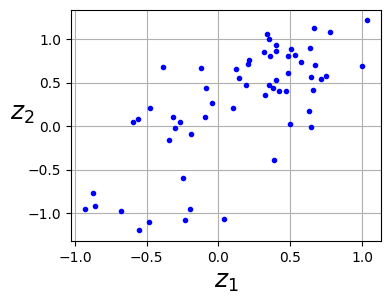

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

**Stacked Autoencoder:**

In [12]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [13]:
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0333 - val_loss: 0.0172
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0166 - val_loss: 0.0158
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0149 - val_loss: 0.0150
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0146 - val_loss: 0.0147
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0143 - val_loss: 0.0144
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0140 - val_loss: 0.0141
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0138 - val_loss: 0.0139
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0135 - val_loss: 0.0137
Epoch 12/20
1719/1719 ━━━━━━━━

In [14]:
import numpy as np

In [16]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


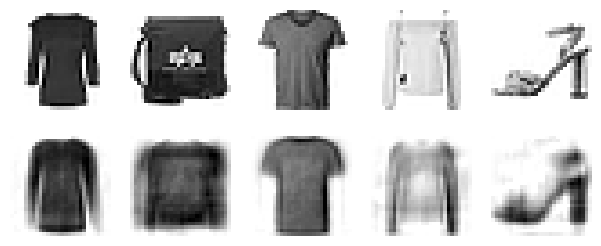

In [17]:
plot_reconstructions(stacked_ae)
plt.show()

Reconstructions are recognisable but too lossy - may need to train the model for longer or make the encoder and decoder deeper, or make the codings larger. But - if we make the nework too powerful - it will manage to makr perfect reconstructions w/o learning any useful patterns. 

**Visualizing the Fashion MNIST Dataset:**
- using tsne

In [21]:
from sklearn.manifold import TSNE

In [18]:
X_valid_compression = stacked_encoder.predict(X_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


In [19]:
X_valid.shape

(5000, 28, 28)

In [20]:
X_valid_compression.shape

(5000, 30)

In [22]:
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compression)

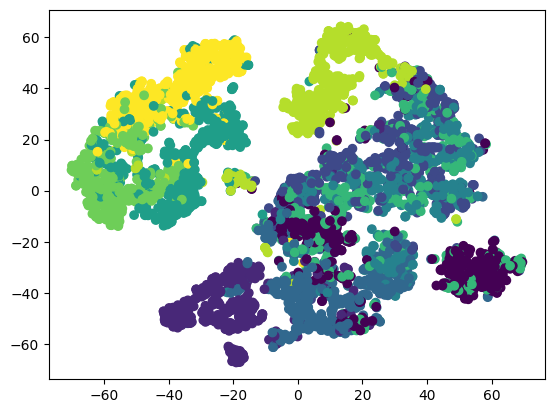

In [24]:
# now, we can plot the dataset
plt.scatter(X_valid_2D[:,0],X_valid_2D[:,1],c=y_valid)
plt.show()

In [26]:
import umap

In [31]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(StandardScaler().fit_transform(X_valid_compression))

In [32]:
embedding.shape

(5000, 2)

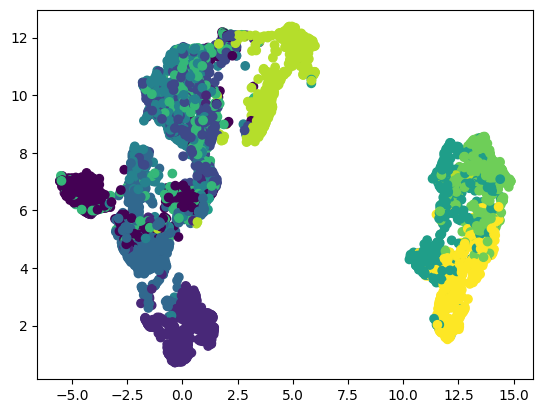

In [33]:
plt.scatter(embedding[:,0],embedding[:,1],c=y_valid)
plt.show()

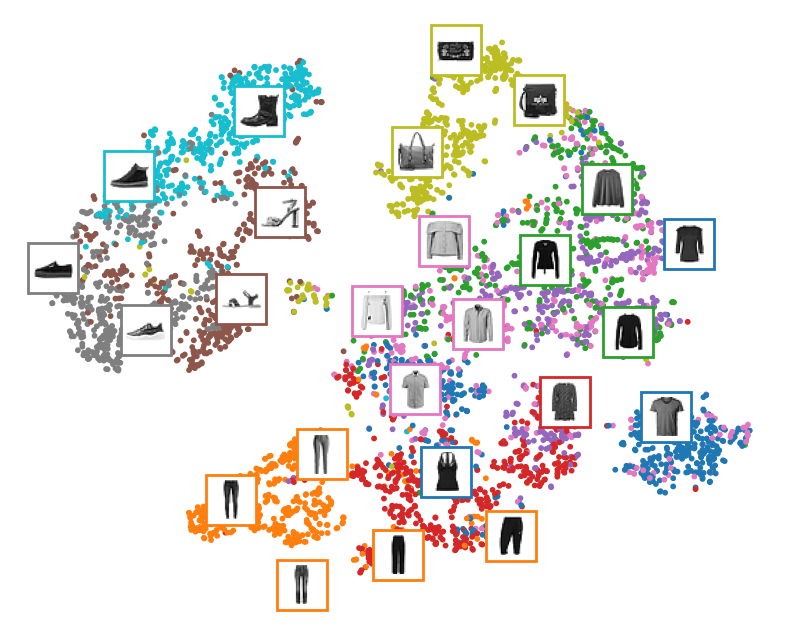

In [36]:
import matplotlib as mpl 

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

**Convolutional Autoencoders:**
- If you're dealing with images => the autoencoders we've seen so far will not work well unless the images are very small
- Here's a basic convolutional autoencoder for fashion mnist:

In [38]:
X_train.shape

(55000, 28, 28)

In [39]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[28,28]),
    tf.keras.layers.Reshape([28, 28, 1]),
    tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 14x14x16
    tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"), 
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 7x7x32
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2), # output: 3x3x64
    tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
    tf.keras.layers.GlobalAvgPool2D() # output: 30
])

conv_encoder.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 3, 3, 30)       │        17,310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 30)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,606 (158.62 KB)

 Trainable params: 40,606 (158.62 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[30]),
    tf.keras.layers.Dense(3*3*16),
    tf.keras.layers.Reshape((3,3,16)),
    tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
    tf.keras.layers.Reshape([28,28])
])

conv_decoder.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 144)            │         4,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 3, 3, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 32)       │         4,640 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           145 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,873 (54.19 KB)

 Trainable params: 13,873 (54.19 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [42]:
conv_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = conv_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0451 - val_loss: 0.0209
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0194 - val_loss: 0.0177
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - loss: 0.0170 - val_loss: 0.0160
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.0131 - val_loss: 0.0133
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0128 - val_loss: 0.0134
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0125 - val_loss: 0.0132


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


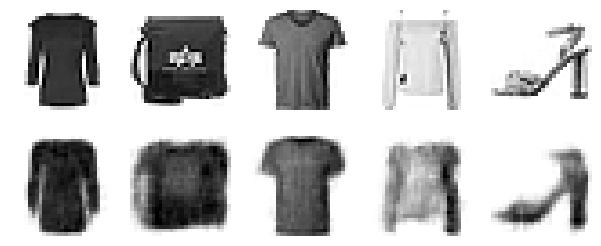

In [43]:
plot_reconstructions(conv_ae)
plt.show()

In [44]:
X_valid_compression = conv_encoder.predict(X_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [45]:
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compression)

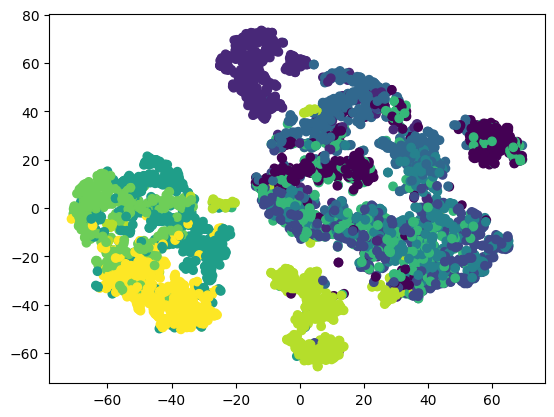

In [46]:
plt.scatter(X_valid_2D[:,0],X_valid_2D[:,1],c=y_valid)
plt.show()

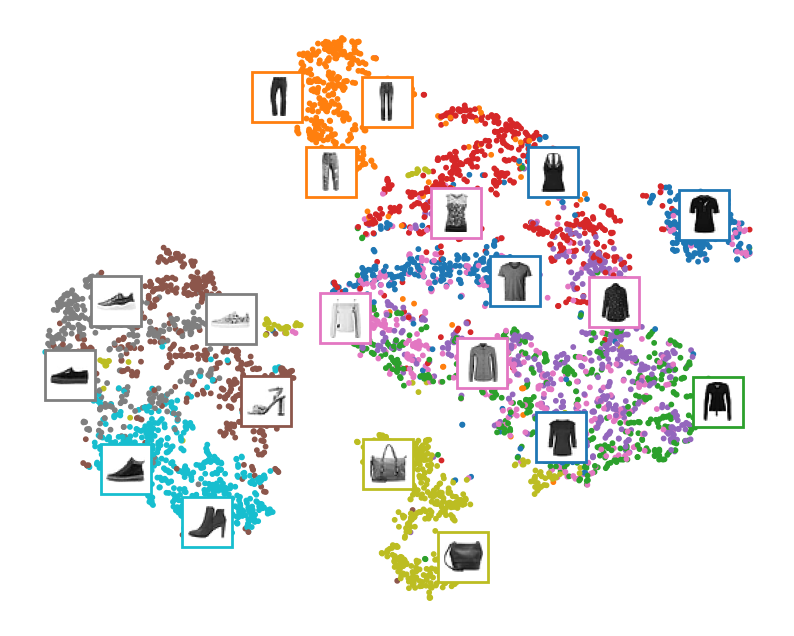

In [47]:
import matplotlib as mpl 

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

**Denoising Autoencoders:**
- Another way to force the autoencoder to learn useful features is to add noise to its inputs - training it to recover the original noise-free inputs.

In [48]:
dropout_encoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[28,28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu")
])

dropout_decoder = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[30]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

dropout_ae = tf.keras.Sequential([dropout_encoder, dropout_decoder])

In [49]:
dropout_encoder.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │         3,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,530 (318.48 KB)

 Trainable params: 81,530 (318.48 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
dropout_decoder.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 784)            │        79,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,284 (321.42 KB)

 Trainable params: 82,284 (321.42 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
dropout_ae.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_13 (Sequential)      │ (None, 30)             │        81,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 28, 28)         │        82,284 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,814 (639.90 KB)

 Trainable params: 163,814 (639.90 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# extra code – compiles and fits the model
dropout_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0399 - val_loss: 0.0210
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0221 - val_loss: 0.0195
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0209 - val_loss: 0.0189
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0203 - val_loss: 0.0184
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0198 - val_loss: 0.0180
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0195 - val_loss: 0.0178
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0192 - val_loss: 0.0176
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0188 - val_loss: 0.0172
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0186 - val_loss: 0.0170


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


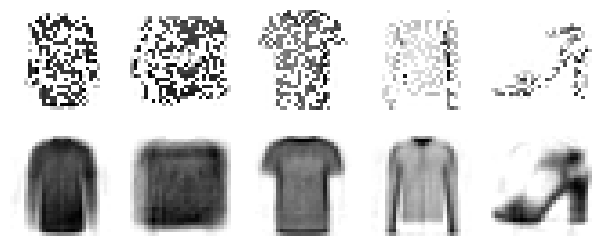

In [54]:
tf.random.set_seed(42)
dropout = tf.keras.layers.Dropout(0.5)
plot_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

**Sparse Autoencoders:**
- increase sparsity in the coding layer so as to force the autoencoder to learn useful features => sparsity may be increased through => using a sigmoid activation in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g. 300 units), and add some l1 regularization to the coding layer's activations. The decoder on the other hand is just a regular decoder. 

In [55]:
sparse_l1_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid"),
    tf.keras.layers.ActivityRegularization(l1=1.0e-4)
])

sparse_l1_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape([28,28])
])

sparse_l1_ae = tf.keras.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0806 - val_loss: 0.0316
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0298 - val_loss: 0.0275
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0243 - val_loss: 0.0234
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0218 - val_loss: 0.0213
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0210 - val_loss: 0.0207
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0204 - val_loss: 0.0201
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0199 - val_loss: 0.0196
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0194 - val_loss: 0.0192


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


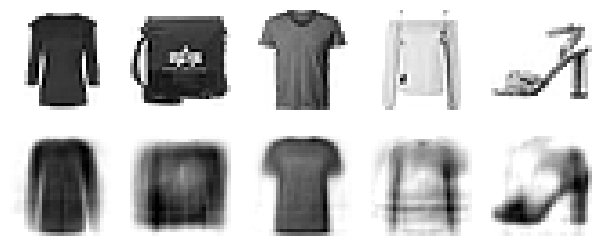

In [56]:
plot_reconstructions(sparse_l1_ae)
plt.show()

In [57]:
kl_divergence = tf.keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, weight, target):
        self.weight = weight
        self.target = target

    def __call__(self, inputs):
        mean_activities = tf.reduce_mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [58]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

kld_reg = KLDivergenceRegularizer(weight=5e-3, target=0.1)
sparse_kl_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation="sigmoid",
                          activity_regularizer=kld_reg)
])
sparse_kl_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
sparse_kl_ae = tf.keras.Sequential([sparse_kl_encoder, sparse_kl_decoder])

# extra code – compiles and fits the model
sparse_kl_ae.compile(loss="mse", optimizer=tf.keras.optimizers.Nadam())
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0711 - val_loss: 0.0227
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0205 - val_loss: 0.0187
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0163 - val_loss: 0.0165
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0141 - val_loss: 0.0143
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0126 - val_loss: 0.0128
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0109 - val_loss: 0.0111
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 9/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 10/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.0099 - val_loss: 0.0100


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


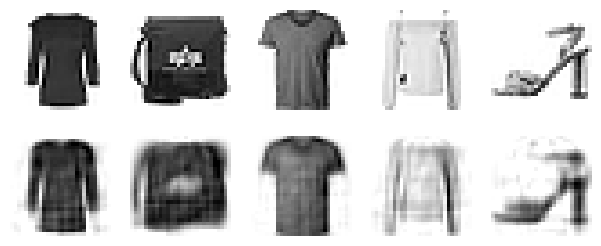

In [59]:
plot_reconstructions(sparse_kl_ae)
plt.show()